In [48]:
import datetime
import pathlib
import re


import pandas as pd
import dask.dataframe as dd

import slr.wind
import slr.psmsl

In [6]:
data_dir = pathlib.Path('~/src/sealevel/data/deltares/gtsm/era5-long').expanduser()
data_dir.exists()

True

In [10]:
mean_files = list(sorted(data_dir.glob('**/*mean*.csv')))

In [34]:
monthly_gtsm_df, annual_gtsm_df = slr.wind.get_gtsm_dfs()
annual_gtsm_df

,t,name,ddl_id,year,surge_mm
0,1979-01-01,Delfzijl,DELFZL,1979,41.701794
1,1979-01-01,Den Helder,DENHDR,1979,45.498066
2,1979-01-01,Harlingen,HARLGN,1979,57.112718
3,1979-01-01,Hoek van Holland,HOEKVHLD,1979,36.467322
4,1979-01-01,IJmuiden,IJMDBTHVN,1979,44.142017
...,...,...,...,...,...
296,2021-01-01,Harlingen,HARLGN,2021,48.043103
297,2021-01-01,Hoek van Holland,HOEKVHLD,2021,23.542115
298,2021-01-01,IJmuiden,IJMDBTHVN,2021,31.139863
299,2021-01-01,NL,NL,2021,32.904800


In [21]:
# Check with Natalia Aleksandrova if we can also derive monthly data
# Last time we got netcdf's in the form of:
# reanalysis_surge_10min_2018_12_v1_monthly_mean.nc
# Can we reuse the same datasets?

In [31]:
main_stations = slr.psmsl.get_main_stations()
main_stations = main_stations.set_index('gtsm_id')

In [26]:
# tijd column
# name
# id -> ddl_id


,2020,0
0,NWS_NO_TS_MO_Vlissingen,0.1468
1,NWS_NO_TS_MO_HoekVanHolland,0.1676
2,NWS_NO_TS_MO_Ijmuiden,0.1868
3,NWS_NO_TS_MO_DenHelder,0.1734
4,NWS_NO_TS_MO_Harlingen,0.2289
5,NWS_NO_TS_MO_Delfzijl,0.3107


In [78]:
path = mean_files[-3]

path_re = re.compile(r'Stations_NL_(?P<year>\d{4})_mean.csv$')


mean_dfs = []
for path in mean_files:
    match = path_re.search(str(path))
    year_str = match.group('year')
    year = int(year_str)
    mean_df_i = pd.read_csv(path)
    mean_df_i = mean_df_i.rename(
        columns={
            year_str: "gtsm_id", 
            "0": "surge_mm"
        }
    )
    t = datetime.datetime(year, 1, 1)
    # TODO: is the data in m?
    mean_df_i['surge_mm'] *= 1000
    # add column to start of dataframe
    mean_df_i['t'] = t
    mean_df_i['year'] = year
    mean_dfs.append(mean_df_i)
mean_df = pd.concat(mean_dfs)



In [79]:
mean_df['ddl_id'] = mean_df.apply(lambda row: main_stations.loc[row['gtsm_id']]['ddl_id'], axis=1)
mean_df['name'] = mean_df.apply(lambda row: main_stations.loc[row['gtsm_id']]['name'], axis=1)
columns = ['t', 'name', 'ddl_id', 'year', 'surge_mm']
mean_df = mean_df[columns]

In [80]:
merged = pd.merge(annual_gtsm_df, mean_df, left_on=['year', 'ddl_id'], right_on=['year', 'ddl_id'], suffixes=('_2022', '_2023'))
merged

,t_2022,name_2022,ddl_id,year,surge_mm_2022,t_2023,name_2023,surge_mm_2023
0,2019-01-01,Delfzijl,DELFZL,2019,68.567996,2019-01-01,Delfzijl,304.0
1,2019-01-01,Den Helder,DENHDR,2019,58.190230,2019-01-01,Den Helder,166.7
2,2019-01-01,Harlingen,HARLGN,2019,76.739505,2019-01-01,Harlingen,216.9
3,2019-01-01,Hoek van Holland,HOEKVHLD,2019,43.308887,2019-01-01,Hoek van Holland,165.8
4,2019-01-01,IJmuiden,IJMDBTHVN,2019,54.278753,2019-01-01,IJmuiden,181.9
5,2019-01-01,Vlissingen,VLISSGN,2019,34.404990,2019-01-01,Vlissingen,147.1
6,2020-01-01,Delfzijl,DELFZL,2020,70.890034,2020-01-01,Delfzijl,310.7
7,2020-01-01,Den Helder,DENHDR,2020,60.040710,2020-01-01,Den Helder,173.4
8,2020-01-01,Harlingen,HARLGN,2020,84.080902,2020-01-01,Harlingen,228.9
9,2020-01-01,Hoek van Holland,HOEKVHLD,2020,40.365151,2020-01-01,Hoek van Holland,167.6


Text(0, 0.5, 'Surge from new data for 2023 [m => mm?]')

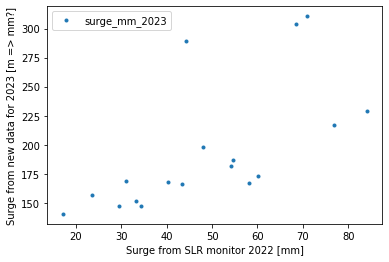

In [89]:
ax = merged.plot('surge_mm_2022', 'surge_mm_2023', style='.')
ax.set_xlabel('Surge from SLR monitor 2022 [mm]')
ax.set_ylabel('Surge from new data for 2023 [m => mm?]')

<Axes: xlabel='year'>

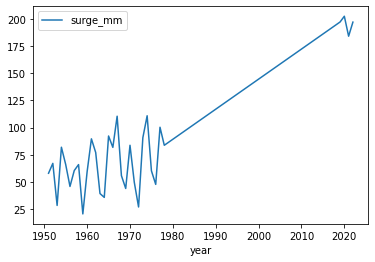

In [96]:
mean_df.groupby('year').mean(numeric_only=True).plot()